# MODIS Water XGBOOST Hyperparameter Tuning

Version: 0.1.0

Date modified: 02.08.2022

Modified by: Caleb Spradlin

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys

import xgboost as xgb

import optuna

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split 
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

sys.path.append('../scripts/')
import notebook_util as nu

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [5]:
FIGURE_OUTPUT_DIR = '/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output'
RASTER_OUTPUT_DIR = '/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output'
MODEL_OUTPUT_DIR = '/att/nobackup/cssprad1/projects/modis_water/models/'

GPU = True
TILE = 'global'
MODEL = 'xgboost'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
# Columns that are offset, years, julian days, etc (always need to be dropped).
offsets_indexes = ['x_offset', 'y_offset']
# Columns that the user wants to drop for training purposes. 
colsToDrop = [] #['sur_refl_b03_1','sur_refl_b04_1','sur_refl_b05_1','ndwi1','ndwi2']
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [6]:
colsToDrop

[]

In [7]:
colsToDropTraining

['x_offset', 'y_offset']

In [8]:
if GPU:
    nu.setup_one_gpu() # Choose the GPU with the lowest memory usage

Picking GPU 0


In [9]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## Data 
- Read in to cuDF Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

In [10]:
glob_string = '/att/nobackup/cssprad1/projects/modis_water/data/training_data/v1.1.0/MOD09_{}_*.parquet.gzip'.format(TILE)
data_paths = [fv for fv in glob.glob(glob_string)]
data_path = data_paths[0]
pprint(data_paths)

['/att/nobackup/cssprad1/projects/modis_water/data/training_data/v1.1.0/MOD09_global_WATER_TR_DATA_#5516128.parquet.gzip']


In [11]:
X_train, X_test, y_train, y_test = load_data(fpath=data_path,
                                             colsToDrop=colsToDropTraining,
                                             dataType=DATA_TYPE,
                                             cpu=True,
                                             splitXY=True,
                                             imbalance=False,
                                             trainTestSplit=True,
                                             multi=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [12]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


In [13]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,3285411.0,458.149911,612.032791,-100.0,34.0,314.0,638.0,16000.0
sur_refl_b02_1,3285411.0,1461.329380,1458.178872,-100.0,2.0,1264.0,2651.0,16000.0
sur_refl_b03_1,3285411.0,312.489014,434.348439,-100.0,141.0,228.0,366.0,15361.0
sur_refl_b04_1,3285411.0,488.443166,517.853717,-100.0,140.0,432.0,661.0,16000.0
sur_refl_b05_1,3285411.0,1588.989535,1532.166785,-100.0,22.0,1402.0,2987.0,16000.0
sur_refl_b06_1,3285411.0,1202.748364,1150.659385,-100.0,94.0,1045.0,2091.0,16000.0
sur_refl_b07_1,3285411.0,661.093323,780.028524,-100.0,50.0,429.0,985.0,14952.0
ndvi,3285411.0,554.566374,8222.850014,-32762.0,-5294.0,2675.0,6713.0,32762.0
ndwi1,3285411.0,-2718.137562,6748.512853,-32759.0,-9166.0,-538.0,2043.0,32767.0
ndwi2,3285411.0,-132.574653,8623.563903,-32758.0,-7342.0,2373.0,5867.0,32767.0


In [14]:
def output_interesting_idx(df, column, threshold, greaterThan=True):
    dfToReturn = df[df[column] > threshold] if \
        greaterThan else df[df[column] < threshold]
    return dfToReturn

In [15]:
output_interesting_idx(X_train, 'ndvi', 32000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
1499928,13,-7,173,78,9,36,10,32203,-14827,8870
4772825,12,-11,133,126,44,83,68,32144,-13055,-13859
263952,26,-14,228,110,21,71,70,32203,-14912,-15000
3830140,30,-16,301,137,45,106,73,32679,-13555,-15614
1026970,-13,7,127,69,0,97,48,32203,-8653,-7454
...,...,...,...,...,...,...,...,...,...,...
4753614,13,-7,138,131,8,89,25,32203,-11707,-17777
571607,84,-45,133,387,-63,81,29,32460,30536,-19286
5252797,-100,54,-100,-100,262,1114,947,32058,-9075,-8921
4948093,13,-7,237,74,20,52,34,32203,-13111,-15185


## XGBOOST

Choose which combination of hyperparameters to train:

- n_estimators: Number of learners for the xgboost to fit.
- booster: Which booster to use
- lamda: L2 regularization rate
- alpha: L1 regularization rate
- subsample: sampling ration for training data
- colsample_bytree: sampling according to each tree
- max_depth: maximum depth of the tree, signifies complexity
- min_child_weight: minimum child weight, the larger the term, the more complex
- gamme: how selective the algorithm is

In [32]:
def objective(trial):
    hyperparameters = {
        "verbosity": 0,
        "learning_rate": 0.003,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "gpu_hist",
        # "gpu_id": 0,
        "n_jobs": -1,
        "n_estimators": trial.suggest_categorical("n_estimators", [200]),
        # defines booster, gblinear for linear functions.
        # "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        # L2 regularization weight.
        # "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        # "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        # "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        # "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        # maximum depth of the tree, signifies complexity of the tree.
        "max_depth":  trial.suggest_int("max_depth", 10, 30, step=5), 
        # minimum child weight, larger the term more conservative the tree.
        # "min_child_weight":  trial.suggest_int("min_child_weight", 2, 10), 
        # "eta":  trial.suggest_float("eta", 1e-8, 1.0, log=True), 
        # defines how selective algorithm is.
        # "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True), 
        # "grow_policy":  trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-auc")
    classifier = xgb.XGBClassifier(**hyperparameters)
    eval_set = [(X_train, y_train), (X_val, y_val)]
    eval_metric = ["error","auc"]
    classifier.fit(X_train, 
                   y_train, 
                   eval_set=eval_set, 
                   eval_metric=eval_metric, 
                   early_stopping_rounds=5, 
                   callbacks=[pruning_callback],
                   verbose=False)
    preds = classifier.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    fp = cm[1][0]
    precision = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print('Confusion matrix')
    print('TP: {:9} FN: {:9}'.format(cm[0][0], cm[0][1]))
    print('FP: {:9} TN: {:9}'.format(cm[1][0], cm[1][1]))
    print('Precision: {}'.format(precision))
    print('F1 score: {}'.format(f1))
    return fp

## Set the search space

Set the search space for the hyperparameter tuning to search through once. This needs to be in conjunction with the `trial.suggest...` part of the hyperparameters dictionary defined aboce. 

Ex.

If `max_depth` is defined in `hyperparameters` in the `objective` function above as such

`"max_depth":  trial.suggest_int("max_depth", 10, 30, step=5),` 

then we need to pair that with the limited search space below as such:

`search_space={"max_depth":[10, 15, 20, 25, 30]}`

This is not the most ideal way of ensuring that trials are not repeated, however it works for now. 

In [33]:
search_space={
    "max_depth":[10, 15, 20, 30],
}

### Set number of trials and timeout

Set the number of trials `n_trials=<num of desired trials>` and the maximum time for the total study `timeout=<timeout in minutes>*60`

In [34]:
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(study_name='xgboost hyperparameter tuning', 
                            direction='minimize',
                            sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective, n_trials=10, timeout=20*60)

[I 2022-02-16 10:26:58,921] A new study created in memory with name: xgboost hyperparameter tuning
[I 2022-02-16 10:27:15,967] Trial 0 finished with value: 14564.0 and parameters: {'n_estimators': 200, 'max_depth': 10}. Best is trial 0 with value: 14564.0.


Confusion matrix
TP:    550454 FN:     29165
FP:     14564 TN:    500954
Precision: 0.9449840507508691
F1 score: 0.9581795594455819


[I 2022-02-16 11:05:02,469] Trial 1 finished with value: 11683.0 and parameters: {'n_estimators': 200, 'max_depth': 30}. Best is trial 1 with value: 11683.0.


Confusion matrix
TP:    552323 FN:     27296
FP:     11683 TN:    503835
Precision: 0.9486077822608735
F1 score: 0.9627582885953171


In [19]:
print("Number of finished trials: {}".format(len(study.trials)))
trials = study.best_trials
trial_score = max([trial.values[0] for trial in trials])
best_trial_params = [trial.params for trial in trials if trial.values[0] == trial_score][0]
print(best_trial_params)
print(trial_score)

trial_scores = [trial.values for trial in trials]
trial_params = [trial.params for trial in trials]

for score, param in zip(trial_scores, trial_params):
    print(score)
    for k, v in param.items():
        print("     {}: {}".format(k, v))

study_df = study.trials_dataframe()
study_df.to_csv("hyperopt_tuning_trial_{}_xgboost.csv".format(
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')))

Number of finished trials: 4
{'n_estimators': 200, 'max_depth': 30}
11687.0
[11687.0]
     n_estimators: 200
     max_depth: 30


In [20]:
study_df

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_n_estimators,system_attrs_grid_id,system_attrs_search_space,state
0,0,12405.0,2022-02-16 09:47:57.219641,2022-02-16 09:48:50.275796,0 days 00:00:53.056155,15,200,1,"{'max_depth': [10, 15, 20, 30]}",COMPLETE
1,1,14622.0,2022-02-16 09:48:50.279062,2022-02-16 09:49:05.319888,0 days 00:00:15.040826,10,200,0,"{'max_depth': [10, 15, 20, 30]}",COMPLETE
2,2,11687.0,2022-02-16 09:49:05.322843,2022-02-16 09:50:49.667154,0 days 00:01:44.344311,30,200,3,"{'max_depth': [10, 15, 20, 30]}",COMPLETE
3,3,11775.0,2022-02-16 09:50:49.670017,2022-02-16 09:52:04.112058,0 days 00:01:14.442041,20,200,2,"{'max_depth': [10, 15, 20, 30]}",COMPLETE


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

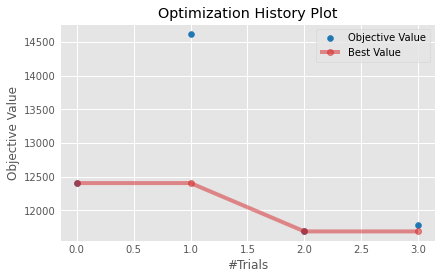

In [21]:
optuna.visualization.matplotlib.plot_optimization_history(study)

<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

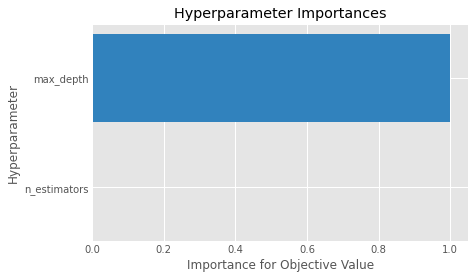

In [22]:
optuna.visualization.matplotlib.plot_param_importances(study)

## Define and train model given the best hyperparameters

In [35]:
hyperparameters = best_trial_params

base_params = {"verbosity": 0,
               "learning_rate": 0.003,
               "objective": "binary:logistic",
               "tree_method": "hist",
               "n_jobs": -1}

hyperparameters.update(base_params)
print('Using these params:')
pprint(hyperparameters)
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["error","auc"]
classifier = xgb.XGBClassifier(**hyperparameters)

Using these params:
{'learning_rate': 0.003,
 'max_depth': 30,
 'n_estimators': 200,
 'n_jobs': -1,
 'objective': 'binary:logistic',
 'tree_method': 'hist',
 'verbosity': 0}


In [36]:
classifier.fit(X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, early_stopping_rounds=10)

[0]	validation_0-error:0.02631	validation_0-auc:0.98928	validation_1-error:0.04133	validation_1-auc:0.98665
[1]	validation_0-error:0.02588	validation_0-auc:0.98934	validation_1-error:0.04059	validation_1-auc:0.98674
[2]	validation_0-error:0.02601	validation_0-auc:0.98935	validation_1-error:0.04041	validation_1-auc:0.98676
[3]	validation_0-error:0.02597	validation_0-auc:0.98938	validation_1-error:0.04025	validation_1-auc:0.98677
[4]	validation_0-error:0.02599	validation_0-auc:0.98942	validation_1-error:0.04011	validation_1-auc:0.98681
[5]	validation_0-error:0.02603	validation_0-auc:0.98950	validation_1-error:0.04003	validation_1-auc:0.98685
[6]	validation_0-error:0.02608	validation_0-auc:0.98953	validation_1-error:0.04000	validation_1-auc:0.98688
[7]	validation_0-error:0.02608	validation_0-auc:0.98955	validation_1-error:0.03993	validation_1-auc:0.98689
[8]	validation_0-error:0.02610	validation_0-auc:0.98958	validation_1-error:0.03987	validation_1-auc:0.98691
[9]	validation_0-error:0.026

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.003, max_delta_step=0, max_depth=30,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=0)

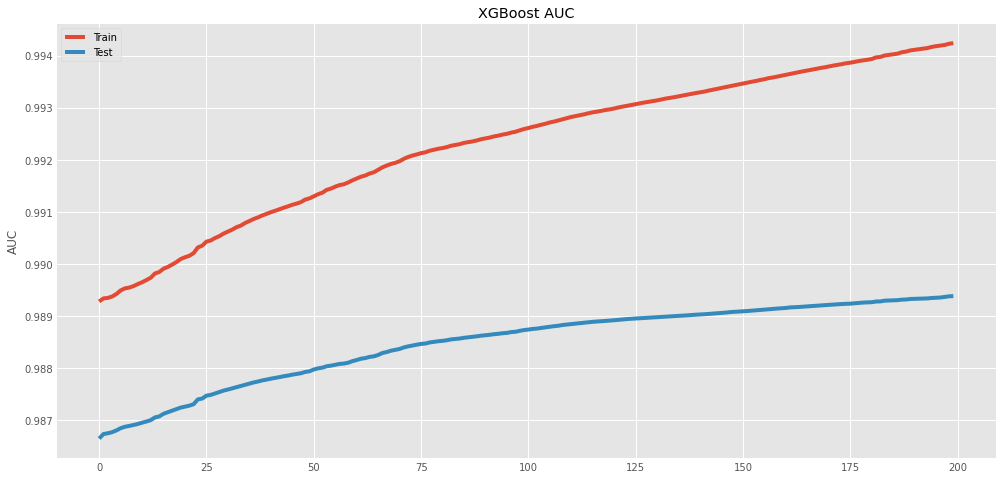

In [37]:
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

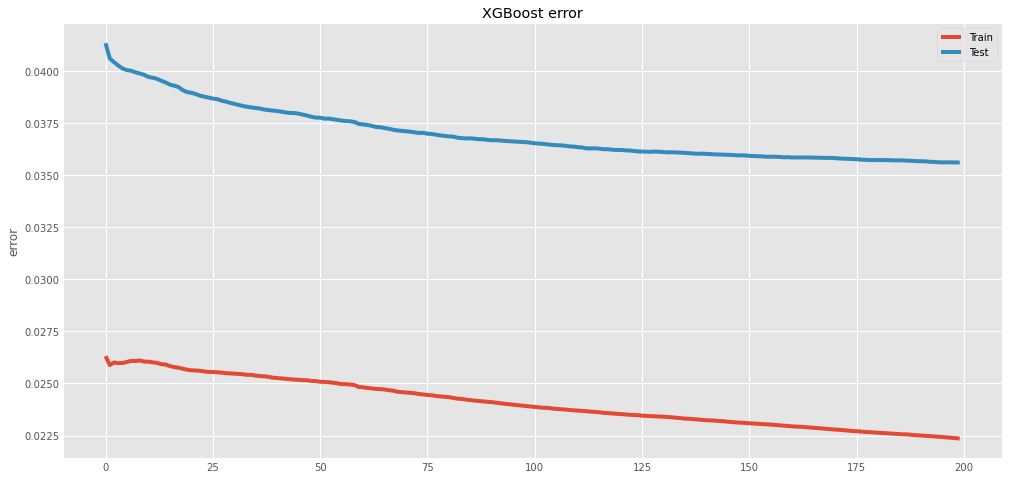

In [38]:
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('error')
plt.title('XGBoost error')
plt.show()

## Model testing and training/testing data validation

### Get model metrics

In [39]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


0.964

In [40]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [41]:
test_predictions = test_predictions.astype(np.int16)
y_test_int = y_test.astype(np.int16)

In [42]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.95      0.97    579619
           1       0.95      0.98      0.96    515518

    accuracy                           0.96   1095137
   macro avg       0.96      0.97      0.96   1095137
weighted avg       0.96      0.96      0.96   1095137

Test Recall
-------------------------------------------------------
0.9528793914623227
Confusion Matrix
-------------------------------------------------------
[[552307  27312]
 [ 11677 503841]]


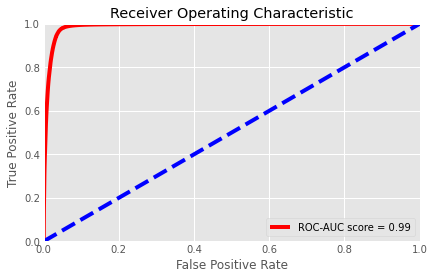

In [43]:
probs = classifier.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC-AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Permutation importance

In [44]:
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

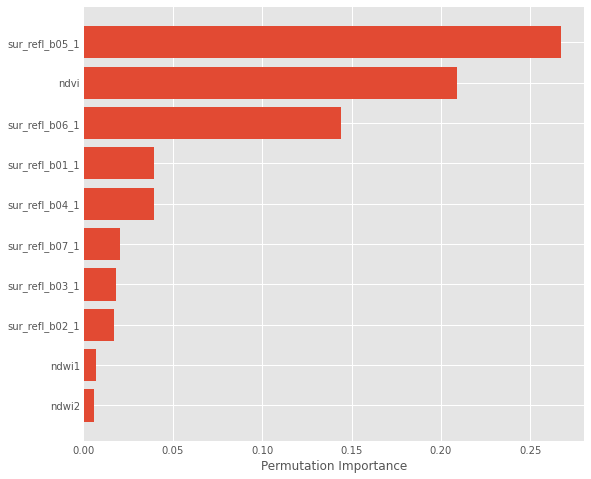

In [45]:
png_save_path = 'mw_{}_{}_{}_{}_{}_permutation_importance.png'.format(
    TILE,
    score,
    hyperparameters['n_estimators'],
    MODEL,
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)

sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig(png_save_path)

In [46]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, y_test_int

## Save the model for future use

In [47]:
model_save_path = 'mw_{}_{}_{}_{}_tuned_{}.sav'.format(TILE,
                                                      score,
                                                      hyperparameters['n_estimators'],
                                                      MODEL,
                                                      'gpu' if GPU else 'cpu',
                                                      datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_save_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: /att/nobackup/cssprad1/projects/modis_water/models/mw_global_0.964_200_xgboost_tuned_gpu.sav
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.003, max_delta_step=0, max_depth=30,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=0)


['/att/nobackup/cssprad1/projects/modis_water/models/mw_global_0.964_200_xgboost_tuned_gpu.sav']

# Testing: Raster testing

In [48]:
TILE = 'h12v09'

In [49]:
DAY = 218
YEAR = 2006
PATH = '/att/nobackup/cssprad1/projects/modis_water/data/test_data/{}/'.format(TILE)

In [50]:
vars_list = [fn for fn in glob.glob(os.path.join(PATH, '*A{}{:03}*.tif'.format(YEAR, DAY)))
            if 'sur_refl' in fn and 'GQ' not in fn]
vars_list.sort()
vars_list

['/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b01_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b02_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b03_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b04_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b05_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b06_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b07_1.tif']

## Get dimensions of inputs

In [51]:
vrt_opts = gdal.BuildVRTOptions(separate=True)
dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_opts)
nrows, ncols = dd.RasterYSize, dd.RasterXSize
dd = None
if os.path.exists('tmp.vrt'):
    os.remove('tmp.vrt') 
nrows, ncols

(4800, 4800)

### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [52]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

In [53]:
im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[6643 7273 6168 ...  452  962 3003]
 [6643 7273 6168 ...  452  962 3003]
 [6172 6885 5686 ...  546  881 2691]
 ...
 [ 419 2432  206 ... 7060 1580 5026]
 [ 751 2327  316 ... 5120 -404 2895]
 [ 751 2327  316 ... 5120 -404 2895]]
460.8 MB size


In [54]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [55]:
predictedRaster, predictedProbaRaster, df = predictRaster(im, colsToDrop=colsToDrop)

Making predictions from raster


In [56]:
shp = (4800, 4800)
left = list()
right = list()
for i, subarr in enumerate(predictedProbaRaster):
    left.append(subarr[0])
    right.append(subarr[1])
leftArr = np.asarray(left)
rightArr = np.asarray(right)
probaLand = leftArr.reshape(shp)
probaWater = rightArr.reshape(shp)

## Inputreshapet raster: description and histogram

In [57]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,23040000.0,406.319013,434.922643,-28672.0,250.0,306.0,360.0,9953.0
sur_refl_b02_1,23040000.0,3162.238815,649.746304,-28672.0,2923.0,3309.0,3518.0,9242.0
sur_refl_b03_1,23040000.0,291.899561,406.622174,-28672.0,166.0,212.0,269.0,9013.0
sur_refl_b04_1,23040000.0,557.999866,406.551242,-28672.0,421.0,493.0,546.0,9716.0
sur_refl_b05_1,23040000.0,3133.262860,632.134972,-28672.0,2923.0,3264.0,3468.0,9040.0
sur_refl_b06_1,23040000.0,1720.846256,526.672817,-28672.0,1506.0,1710.0,1812.0,7103.0
sur_refl_b07_1,23040000.0,530.845410,1843.350129,-28672.0,480.0,547.0,610.0,6316.0
ndvi,23040000.0,7686.235761,2031.676702,-32222.0,7954.0,8349.0,8546.0,32203.0
ndwi1,23040000.0,2985.519139,1161.269606,-32727.0,2979.0,3300.0,3518.0,32620.0
ndwi2,23040000.0,6634.247958,1770.533043,-32727.0,6823.0,7209.0,7398.0,32679.0


Text(0.5, 1.0, 'Distribution of each band and calculated idx')

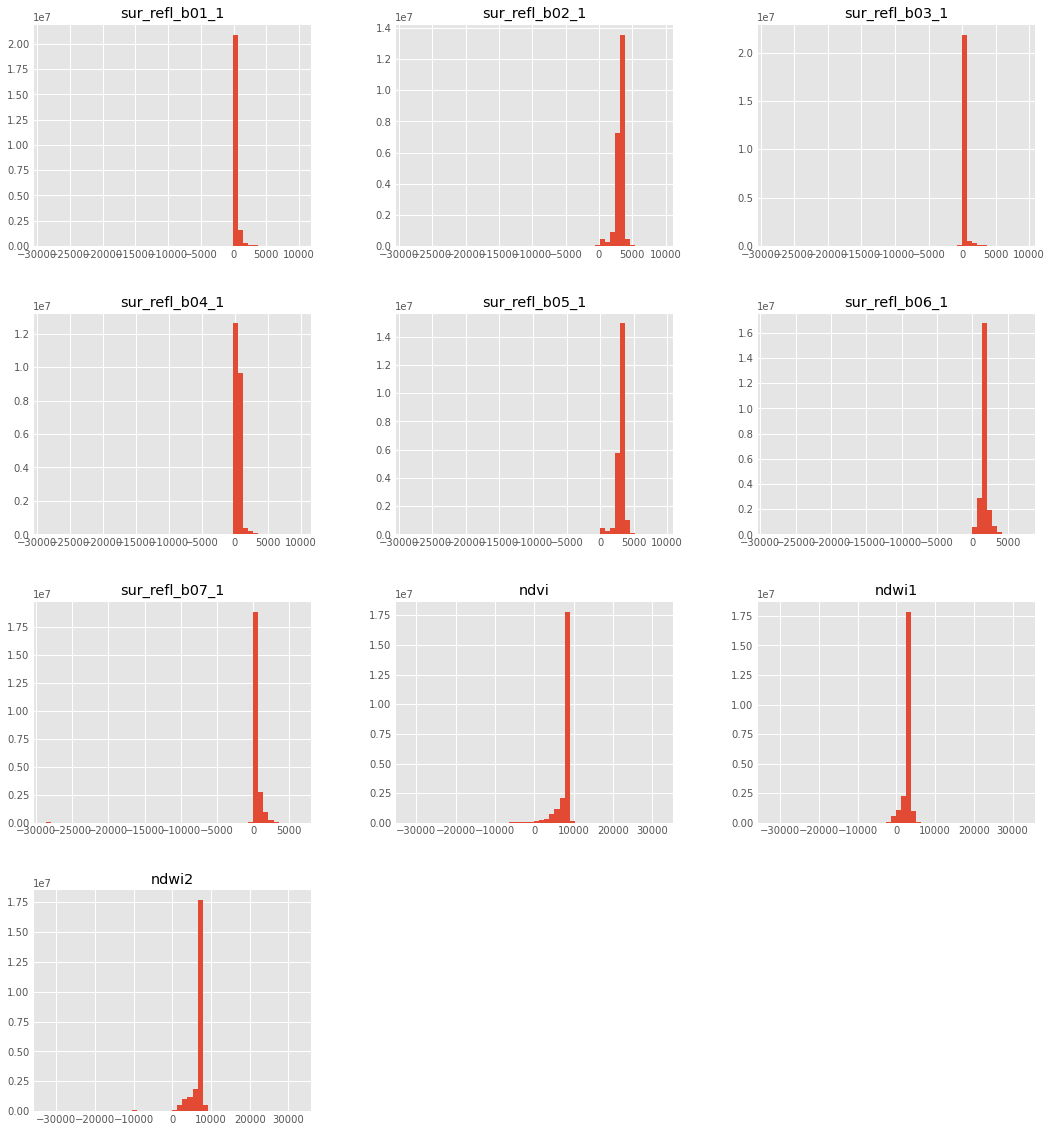

In [58]:
df.hist(figsize=(16, 20), bins=50)
plt.title('Distribution of each band and calculated idx')

#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [59]:
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

(4800, 4800)

### Import the QA Mask and the Water Mask for the h09v05 TILE

In [60]:
qaMask = '/att/nobackup/cssprad1/projects/modis_water/data/qa_masks'
waterMask = '/att/nobackup/cssprad1/projects/modis_water/data/water_masks/Min2000_2019'
qa_list = [fn for fn in glob.glob(os.path.join(qaMask, '*A{}{:03}.{}*bad_good_mask.tif'.format(YEAR, DAY, TILE)))]
water_list = [fn for fn in glob.glob(os.path.join(waterMask, '*{}*.tif'.format(TILE)))]
qa_mask = qa_list[0]
water_mask = water_list[0]
print(water_mask)
print(qa_mask)
ds = gdal.Open(qa_mask, gdal.GA_ReadOnly)
waterMask = gdal.Open(water_mask, gdal.GA_ReadOnly)
qaMaskMatrix = ds.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMaskMatrix = waterMask.GetRasterBand(1).ReadAsArray().astype(np.int16)
ds = None
waterMask = None

/att/nobackup/cssprad1/projects/modis_water/data/water_masks/Min2000_2019/MOD44W_h12v09_min2000_2019.tif
/att/nobackup/cssprad1/projects/modis_water/data/qa_masks/MOD09GA.A2006218.h12v09.061.2020268185436_bad_good_mask.tif


In [61]:
waterMaskMatrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

### Mask out results if QA Mask says pixel is "bad"
Mask out water mask if QA Mask says pixel is "bad"

In [62]:
maskedResult = np.where(qaMaskMatrix == 0, reshp, -9999)
maskedResultProba = np.where(qaMaskMatrix == 0, probaWater, -9999)
waterMasked = np.where(qaMaskMatrix == 0, waterMaskMatrix, -9999)
waterMaskRavel = waterMasked.ravel()
imWater = (waterMaskRavel == 1)

# Generating stats for predicted and truth

## Predicted Raster

In [63]:
TILE = 'global_xgboost_{}'.format(TILE)

Text(0.5, 1.0, 'Predicted water mask')

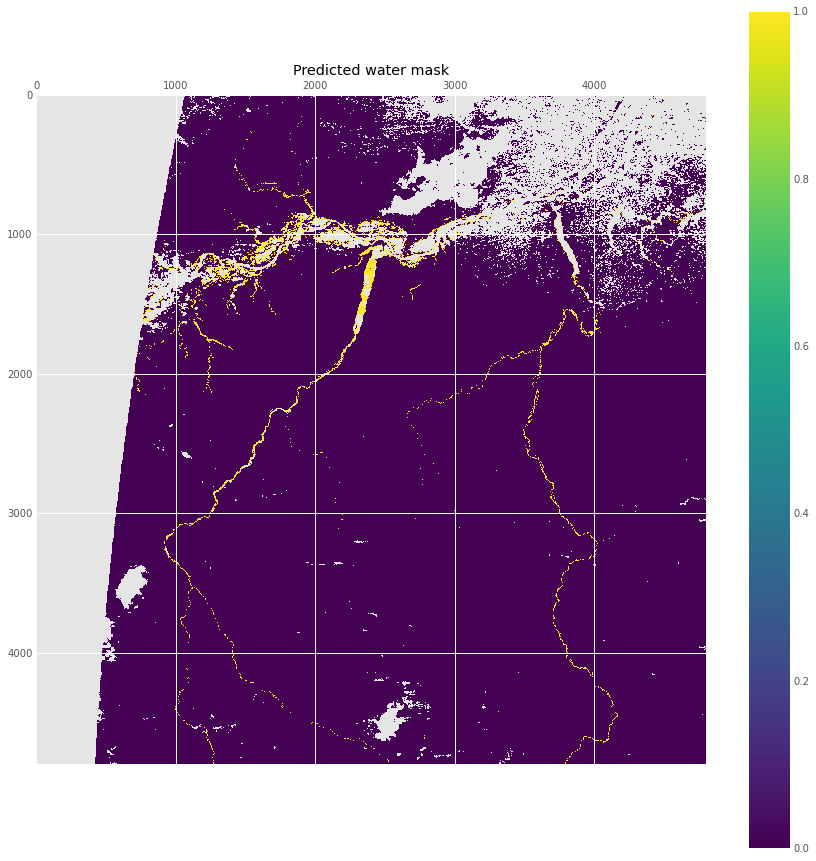

In [64]:
plt.figure(figsize=(15, 15))
outputPlt = plt.matshow(np.where(maskedResult == -9999, np.NaN, maskedResult), fignum=1)
plt.colorbar()
plt.title('Predicted water mask')

## Predicted Probabilities

Text(0.5, 1.0, 'Predicted probabilities of water')

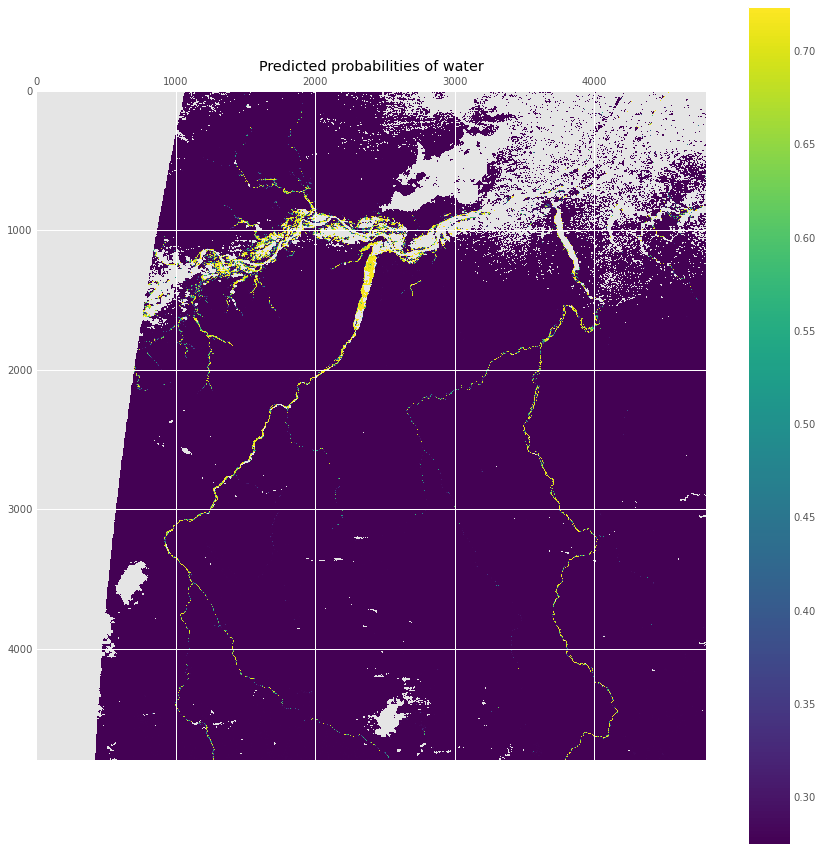

In [65]:
plt.figure(figsize=(15, 15))
outputPlt = plt.matshow(np.where(maskedResult == -9999, np.NaN, maskedResultProba), fignum=1)
plt.colorbar()
plt.title('Predicted probabilities of water')

## Minimum extent water mask

Text(0.5, 1.0, 'Minimum extent water mask')

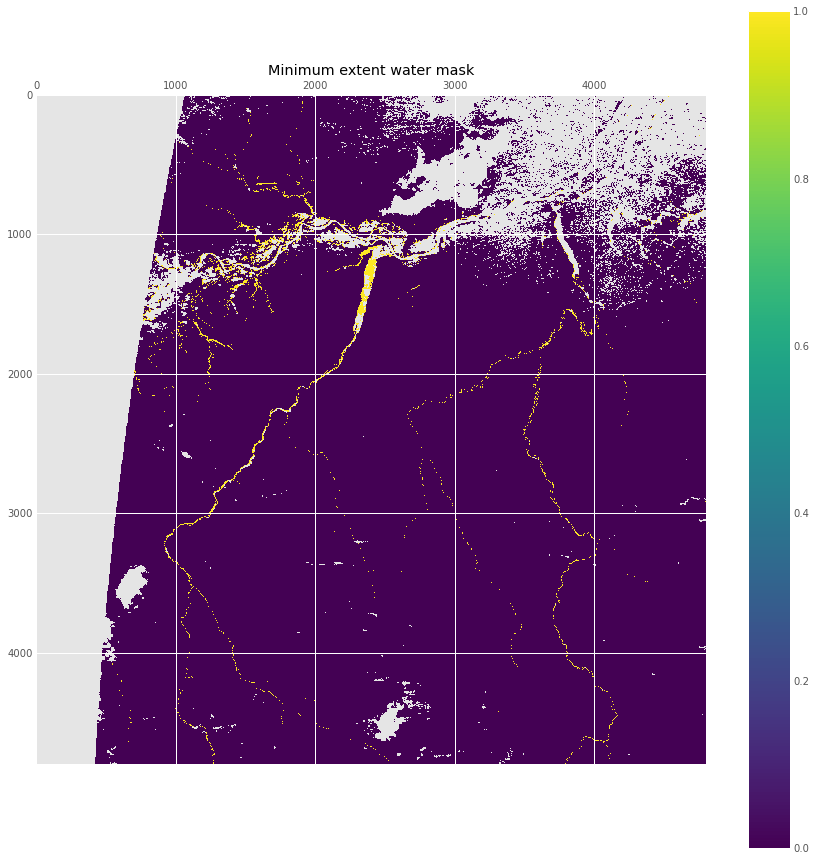

In [66]:
plt.figure(figsize=(15, 15))
truth = np.where(waterMasked==-9999, np.NaN, waterMasked)
truth = np.where(waterMasked==250, np.NaN, truth)
truthPlt = plt.matshow(truth, fignum=1)
plt.colorbar()
plt.title('Minimum extent water mask')

## Metrics on test raster

In [67]:
tp = np.where((waterMasked == 1) & (maskedResult == 1), 1, 0)
tn = np.where((waterMasked == 0) & (maskedResult == 0), 1, 0)
fp = np.where((waterMasked == 0) & (maskedResult == 1), 1, 0)
fn = np.where((waterMasked == 1) & (maskedResult == 0), 1, 0)
total = np.count_nonzero(waterMasked == 1) + np.count_nonzero(waterMasked == 0)
truePositives = np.count_nonzero(tp == 1)
trueNegatives = np.count_nonzero(tn == 1)
falsePositives = np.count_nonzero(fp == 1)
falseNegatives = np.count_nonzero(fn == 1)
accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)
jians = truePositives / (truePositives + trueNegatives)
pc = truePositives / (truePositives + falsePositives)
rc = truePositives / (truePositives + falseNegatives)
f1 = truePositives / (truePositives + (0.5*(falsePositives + falseNegatives)))

### Count num of occurences for each class with the masked predicted result

In [68]:
countNoData = np.count_nonzero(maskedResult == -9999)
countLand = np.count_nonzero(maskedResult == 0)
countWater = np.count_nonzero(maskedResult == 1)
print('Predicted\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

Predicted
 Nodata occurences: 5364592
 Land occurance: 17415932
 Water occurances: 259476


### Count num of occurences for each class with the water mask

In [69]:
countNoDataT = np.count_nonzero(waterMasked == -9999)
countLandT = np.count_nonzero(waterMasked == 0)
countWaterT = np.count_nonzero(waterMasked == 1)
print('Truth Vals\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoDataT, countLandT, countWaterT))

Truth Vals
 Nodata occurences: 5364592
 Land occurance: 17468360
 Water occurances: 207048


### Model metrics on raster data

In [70]:
print('Metrics of Accuracy for Raster Test Data')
print('True Positives:  {}'.format(truePositives))
print('True Negatives:  {}'.format(trueNegatives))
print('False Positives: {}'.format(falsePositives))
print('False Negatives: {}'.format(falseNegatives))
print('Total "good" data: {}'.format(total))
print('Accuracy*: {}'.format(accuracy))
print('Precision: {}'.format(pc))
print('Recall: {}'.format(rc))
print('f1: {}'.format(f1))

Metrics of Accuracy for Raster Test Data
True Positives:  159432
True Negatives:  17368316
False Positives: 100044
False Negatives: 47616
Total "good" data: 17675408
Accuracy*: 0.9916460202785701
Precision: 0.6144383295564908
Recall: 0.7700243421815232
f1: 0.6834889523368572


## Output predicted raster to GeoTiff

In [71]:
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))
print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output probabilies raster masked by good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPathProba, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResultProba)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output/2006_218_global_xgboost_h12v09_predicted_xgboost.tif
/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output/waterMask_2006_qa_218.tif
/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output/2006_218_global_xgboost_h12v09_predicted_probabilities_xgboost.tif
Transform
(-6671703.118, 231.656358, 0.0, 0.0, 0.0, -231.656358)
Projection
PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Width
4800
Height
4800
